# DNN 网络检测判断是否有糖尿病
本节仍属于 [PyTorch深度学习：深度神经网络（DNN）](https://www.bilibili.com/video/BV1Z8411R7PH) 的范畴，另起一页是为了自己重新写一遍。

前置库安装：
- pip install pandas openpyxl

# 笔记
数组与张量之间可以相互转换：
- 数组 arr 转为张量 ts：ts = torch.tensor(arr);
- 张量 ts 转为数组 arr：arr = np.array(ts)。

In [85]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

In [86]:
# 读取训练集，将 numpy 对象转化为 张量 形式。（和视频中的处理方法不一样）
df = pd.read_excel("./data/糖尿病患者记录.xlsx")
ts = torch.tensor(df.to_numpy()[:, 1:]).float()  # 转化为 numpy 并转化为 张量，去掉第一列的 index
# float 转化格式类型，不然训练的时候会报错 RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [87]:
# 打乱训练集
ts = ts[torch.randperm(len(ts)), :].to('cuda')

# 划分训练集和测试集
train_data = ts[:int(len(ts) * 0.7), :]
test_data = ts[int(len(ts) * 0.7):, :]

print(train_data.shape, test_data.shape)

torch.Size([531, 9]) torch.Size([228, 9])


In [36]:
# 8 - 25 - 25 - 25 - 1 全使用 ReLU 激活（输出除外），8000轮，准确率只有 77%，多一层也只有 77%
# 8 - 35 - 35 - 35 - 1 全使用 ReLU 激活（输出除外），8000轮，准确率只有 75%
# 8 - 25 - 25 - 25 - 1 全使用 Sigmoid 激活，8000轮，准确率只有 77%
# 8 - 25 - 15 - 8 - 1 全使用 ReLU 激活（输出除外），8000轮，准确率只有 77%，加上第一个 Dropout(0.7) 也是如此
# 8 - 150 - 100 - 100 - 100 - 100 - 50 - 1 ReLU 激活，0.01 学习率, 8000 轮 74%
# 8 - 35 - Dropout(0.7) - 35 - 35 - 1 全使用 ReLU 激活（输出除外），8000轮，准确率有 80% ，在轮数加大的情况下可以达到 83% 左右

In [94]:
# 按照刚才的说法，应该是输入是 8 个，输出为 1 个（做二分类，输出概率）
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 35), nn.ReLU(),
            nn.Linear(35, 35), nn.ReLU(),
            nn.Linear(35, 35), nn.ReLU(),
            nn.Linear(35, 1), nn.Sigmoid()  # Sigmoid 用于做二分类激活输出
        )

    def forward(self, x):
        return self.net(x)

In [95]:
# 初始化网络
net = Net().to('cuda')
# 定义训练参数
learning_rate = 0.01  # 学习率
loss_fn = nn.BCELoss()  # 损失函数 BCELoss 专门做二次分类
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [96]:
# 测试数据
def test():
    X = test_data[:, :-1]
    Y = test_data[:, -1].reshape(-1, 1)

    with torch.no_grad():
        pred = net(X)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        return (pred == Y).sum() / len(X) * 100

tensor(35.0877, device='cuda:0') 0
tensor(36.4035, device='cuda:0') 4
tensor(38.1579, device='cuda:0') 5
tensor(39.0351, device='cuda:0') 9
tensor(39.4737, device='cuda:0') 11
tensor(41.2281, device='cuda:0') 12
tensor(45.6140, device='cuda:0') 13
tensor(48.2456, device='cuda:0') 15
tensor(50., device='cuda:0') 16
tensor(52.1930, device='cuda:0') 17
tensor(53.0702, device='cuda:0') 18
tensor(57.4561, device='cuda:0') 20
tensor(63.5965, device='cuda:0') 23
tensor(64.0351, device='cuda:0') 24
tensor(64.4737, device='cuda:0') 29
tensor(68.4211, device='cuda:0') 34
tensor(68.8596, device='cuda:0') 1575
tensor(69.2982, device='cuda:0') 1617
tensor(70.6140, device='cuda:0') 1665
tensor(71.0526, device='cuda:0') 1725
tensor(71.9298, device='cuda:0') 1751
tensor(72.3684, device='cuda:0') 1799
tensor(72.8070, device='cuda:0') 1856
tensor(73.2456, device='cuda:0') 1906
tensor(74.1228, device='cuda:0') 1931
tensor(74.5614, device='cuda:0') 1955
tensor(75., device='cuda:0') 2082
tensor(75.4386, de

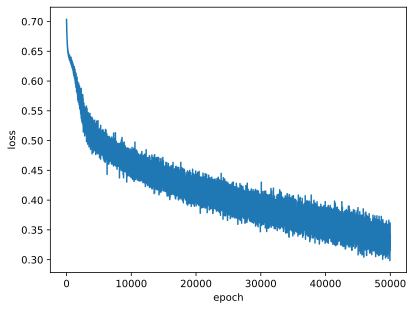

In [97]:
# 开始训练
epochs = 50000
losses = []

X = train_data[:, :-1]
Y = train_data[:, -1].reshape(-1, 1)  # 把 0 1 0 0 变为 [0] [1] [0] [0]

max_acc = 0
for _ in range(epochs):
    pred = net(X)
    loss = loss_fn(pred, Y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    x = test()
    if x > max_acc:
        max_acc = x
        print(max_acc, _)

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 小批量梯度下降
小批量输入有更好的泛化效果，但是由于训练集不够不能找到合适的规律，上下两种方式最高仅有 85% 的准确率。

In [61]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [73]:
class MyDataset(Dataset):
    def __init__(self, filename="./data/糖尿病患者记录.xlsx"):
        self.df = pd.read_excel(filename)
        self.ts = torch.tensor(df.to_numpy()[:, 1:]).float()
        self.X = ts[:, :-1]
        self.Y = ts[:, -1].reshape(-1, 1)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.X.shape[0]

data = MyDataset()
train_data, test_data = random_split(data, [int(len(data) * 0.7), len(data) - int(len(data) * 0.7)])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# 测试数据
def test():
    with torch.no_grad():
        total = 0
        correct = 0
        for x, y in test_loader:
            pred = net(x)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            total += len(x)
            correct += pred.eq(y).sum()
        return correct / total * 100

tensor(34.6491, device='cuda:0') 0
tensor(36.8421, device='cuda:0') 3
tensor(46.9298, device='cuda:0') 4
tensor(59.2105, device='cuda:0') 5
tensor(63.1579, device='cuda:0') 6
tensor(66.2281, device='cuda:0') 7
tensor(66.6667, device='cuda:0') 344
tensor(67.1053, device='cuda:0') 353
tensor(67.5439, device='cuda:0') 362
tensor(67.9825, device='cuda:0') 367
tensor(68.4211, device='cuda:0') 376
tensor(68.8596, device='cuda:0') 385
tensor(69.2982, device='cuda:0') 386
tensor(69.7368, device='cuda:0') 390
tensor(70.1754, device='cuda:0') 394
tensor(71.4912, device='cuda:0') 395
tensor(71.9298, device='cuda:0') 397
tensor(72.3684, device='cuda:0') 399
tensor(72.8070, device='cuda:0') 400
tensor(73.6842, device='cuda:0') 407
tensor(74.1228, device='cuda:0') 409
tensor(74.5614, device='cuda:0') 414
tensor(75., device='cuda:0') 415
tensor(75.8772, device='cuda:0') 421
tensor(76.3158, device='cuda:0') 436
tensor(76.7544, device='cuda:0') 448
tensor(77.1930, device='cuda:0') 539
tensor(77.6316, d

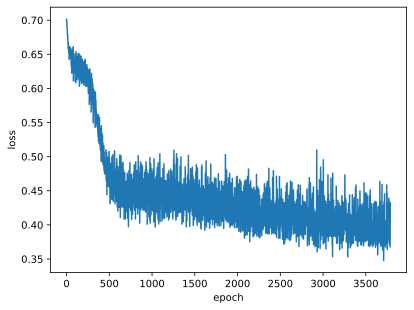

In [84]:
# 初始化网络
net = Net().to('cuda')
# 定义训练参数
learning_rate = 0.01  # 学习率
loss_fn = nn.BCELoss()  # 损失函数 BCELoss 专门做二次分类
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# 开始训练
epochs = 3787
losses = []

max_acc = 0
for _ in range(epochs):
    ave_loss = 0
    total = 0
    for x, y in train_loader:
        total += 1
        pred = net(x)
        loss = loss_fn(pred, y)
        ave_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ave_loss /= total
    losses.append(ave_loss.item())
    # x = test()
    # if x > max_acc:
    #     max_acc = x
    #     print(max_acc, _)

print(test())
Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()